In [45]:
import matplotlib.pyplot as plt
%matplotlib inline

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
import torch.optim  as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data.sampler import SubsetRandomSampler

# check if CUDA is available
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

device = torch.device('cuda:0' if train_on_gpu else 'cpu')

CUDA is available!  Training on GPU ...


## Part 1

In [46]:
torch.__version__

'1.6.0+cu101'

In [47]:
torchvision.__version__

'0.7.0+cu101'

In [48]:
np.__version__

'1.18.5'

In [49]:
import sklearn
sklearn.__version__

'0.22.2.post1'

In [50]:
import matplotlib
matplotlib.__version__

'3.2.2'

## Part 2

Time for the “Hello World” of deep learning: train a handwritten digit classifier using PyTorch. The choice of the network architecture is up to you, the goal is to simply get at least 95% accuracy on the test set! Note that the MNIST dataset is already available as part of the torchvision package.

In [51]:
from torchvision import datasets

In [52]:
dataset_mnist_train = torchvision.datasets.MNIST('/files/', train = True, download = True,
                             transform=torchvision.transforms.Compose([torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize((0.1307,), (0.3081,))
                             ]))

dataset_mnist_test =  torchvision.datasets.MNIST('/files/', train = False, download = True,
                             transform=torchvision.transforms.Compose([torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize((0.1307,), (0.3081,))
                             ]))

In [53]:
from sklearn.model_selection import train_test_split

In [54]:
batch_size_train = 32
n_epochs = 3
batch_size_test = 1000

In [55]:
# number of subprocesses to use for data loading
num_workers = 0

# percentage of training set to use as validation
valid_size = 0.2

targets = dataset_mnist_train.targets
train_idx, valid_idx = train_test_split(np.arange(len(targets)), test_size = valid_size,  stratify = targets)

# define samplers for obtaining training and validation batches
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

In [56]:
train_loader = torch.utils.data.DataLoader(dataset_mnist_train , batch_size = batch_size_train, sampler = train_sampler,  num_workers=num_workers)
valid_loader = torch.utils.data.DataLoader(dataset_mnist_train, batch_size =  batch_size_train, sampler = valid_sampler, num_workers=num_workers)
test_loader = torch.utils.data.DataLoader(dataset_mnist_test, batch_size = batch_size_train,  num_workers = num_workers)

In [57]:
len(train_loader.sampler)

48000

In [58]:
len(valid_loader.sampler)

12000

In [59]:
len(valid_idx)

12000

In [60]:
print("train",np.unique((targets[train_idx]), return_counts = True))
print("valid",np.unique((targets[valid_idx]), return_counts = True))

train (array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]), array([4738, 5394, 4766, 4905, 4674, 4337, 4734, 5012, 4681, 4759]))
valid (array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]), array([1185, 1348, 1192, 1226, 1168, 1084, 1184, 1253, 1170, 1190]))


In [61]:
batch_img = enumerate(valid_loader)
batch_idx, (example_data, example_targets) = next(batch_img)

In [62]:
example_data.shape

torch.Size([32, 1, 28, 28])

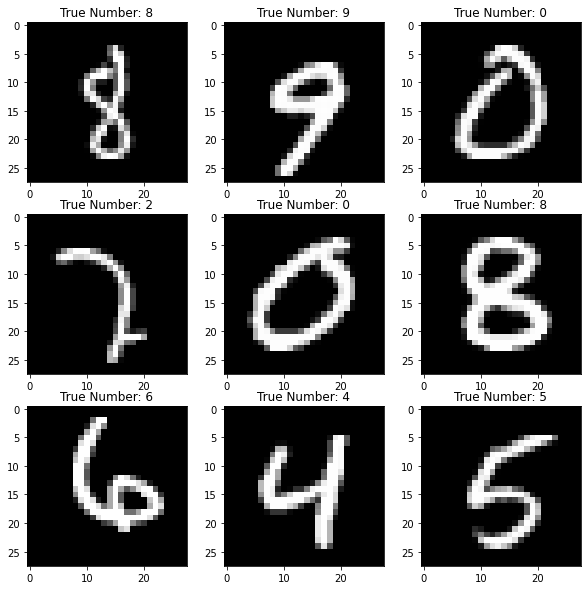

In [63]:
fig, axes = plt.subplots(3, 3, figsize = (10, 10))
axes = axes.ravel()

for i in range(0, 9):
  axes[i].imshow(example_data[i][0], cmap='gray', interpolation='none')
  axes[i].set_title("True Number: {}".format(example_targets[i]))

#### model training

In [64]:
class MNISTNet(nn.Module):
    def __init__(self):
        super(MNISTNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size = 3)
        self.conv2 = nn.Conv2d(16, 20, kernel_size = 5)
        self.conv2_drop = nn.Dropout2d()
        self.pool = nn.MaxPool2d(2, 2)
        # linear layer (64 * 4 * 4 -> 500)
        self.fc1 = nn.Linear(64 * 4 * 4, 500)

        self.fc1 = nn.Linear(320, 50)
        self.dropout = nn.Dropout(0.25)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x)

In [117]:
learning_rate = 0.001
momentum = 0.5
log_interval = 10
n_epochs = 30
model = MNISTNet()

optimizer = optim.SGD(model.parameters(), lr = learning_rate,
                      momentum=momentum)

In [118]:
criterion = nn.CrossEntropyLoss()

# specify optimizer
optimizer = optim.SGD(model.parameters(), lr=0.001)

In [119]:
# create a complete CNN

print(model)

# move tensors to GPU if CUDA is available
model.cuda()

MNISTNet(
  (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(16, 20, kernel_size=(5, 5), stride=(1, 1))
  (conv2_drop): Dropout2d(p=0.5, inplace=False)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=320, out_features=50, bias=True)
  (dropout): Dropout(p=0.25, inplace=False)
  (fc2): Linear(in_features=50, out_features=10, bias=True)
)


MNISTNet(
  (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(16, 20, kernel_size=(5, 5), stride=(1, 1))
  (conv2_drop): Dropout2d(p=0.5, inplace=False)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=320, out_features=50, bias=True)
  (dropout): Dropout(p=0.25, inplace=False)
  (fc2): Linear(in_features=50, out_features=10, bias=True)
)

In [120]:
n_epochs = 30

valid_loss_min = np.Inf # track change in validation loss
train_history = []
valid_history = []



for epoch in range(1, n_epochs+1):

    # keep track of training and validation loss
    train_loss = 0.0
    valid_loss = 0.0
    
    ###################
    # train the model #
    ###################
    model.train()
    correct_train = 0
    correct_valid = 0

    for data, target in train_loader:
        # move tensors to GPU if CUDA is available
        if train_on_gpu:
            data, target = data.cuda(), target.cuda()
        # clear the gradients of all optimized variables
        optimizer.zero_grad()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the batch loss
        loss = criterion(output, target)
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # perform a single optimization step (parameter update)
        optimizer.step()
        # update training loss
        train_loss += loss.item()*data.size(0)

        pred_train = output.data.max(1, keepdim=True)[1]
        correct_train += pred_train.eq(target.data.view_as(pred_train)).sum()  


    ######################    
    # validate the model #
    ######################
    model.eval()
    for data, target in valid_loader:
        # move tensors to GPU if CUDA is available
        if train_on_gpu:
            data, target = data.cuda(), target.cuda()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the batch loss
        loss = criterion(output, target)
        # update average validation loss 
        valid_loss += loss.item()*data.size(0)

        pred_valid = output.data.max(1, keepdim=True)[1]
        correct_valid += pred_valid.eq(target.data.view_as(pred_valid)).sum() 

    # calculate average losses
    train_loss = train_loss/len(train_loader.sampler)
    valid_loss = valid_loss/len(valid_loader.sampler)
    
    # calculate the accuracy
    accuracy_train = 100. * correct_train / len(train_loader.sampler)
    accuracy_valid = 100. * correct_valid/ len(valid_loader.sampler)

    train_history.append([train_loss, accuracy_train])    
    valid_history.append([valid_loss, accuracy_valid])


    print('Epoch: {} \tTraining Loss {:.6f} - Accuracy:  {:.6f} \tValidation Loss {:.6f} -  Accuracy: {:.6f}'.format(
        epoch, train_loss, accuracy_train,  valid_loss, accuracy_valid))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:22: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


Epoch: 1 	Training Loss 2.260689 - Accuracy:  14.431250 	Validation Loss 2.113387 -  Accuracy: 57.549999
Epoch: 2 	Training Loss 1.832102 - Accuracy:  38.660416 	Validation Loss 1.138596 -  Accuracy: 73.533333
Epoch: 3 	Training Loss 1.177001 - Accuracy:  60.974998 	Validation Loss 0.614930 -  Accuracy: 85.324997
Epoch: 4 	Training Loss 0.875760 - Accuracy:  71.562500 	Validation Loss 0.464548 -  Accuracy: 87.724998
Epoch: 5 	Training Loss 0.741969 - Accuracy:  76.408333 	Validation Loss 0.387143 -  Accuracy: 89.449997
Epoch: 6 	Training Loss 0.654054 - Accuracy:  79.479164 	Validation Loss 0.337398 -  Accuracy: 90.483330
Epoch: 7 	Training Loss 0.600381 - Accuracy:  81.337502 	Validation Loss 0.307637 -  Accuracy: 91.283333
Epoch: 8 	Training Loss 0.567275 - Accuracy:  82.525002 	Validation Loss 0.282965 -  Accuracy: 91.691666
Epoch: 9 	Training Loss 0.531390 - Accuracy:  83.420830 	Validation Loss 0.265373 -  Accuracy: 92.299995
Epoch: 10 	Training Loss 0.504077 - Accuracy:  84.54791

### Loss 


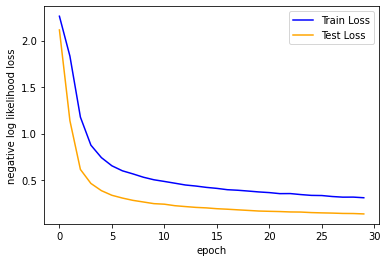

In [121]:
fig = plt.figure()

plt.plot(range(n_epochs), np.array(train_history)[0:, 0], color = 'blue')
plt.plot(range(n_epochs), np.array(valid_history)[0:, 0], color = 'orange')

plt.legend(['Train Loss', 'Test Loss'], loc = 'upper right')
plt.xlabel('epoch')
plt.ylabel('negative log likelihood loss')
plt.show()

### Accuracy


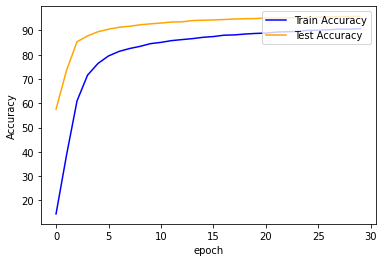

In [122]:
fig = plt.figure()

plt.plot(range(n_epochs), np.array(train_history)[:, 1:], color = 'blue')
plt.plot(range(n_epochs), np.array(valid_history)[:, 1:], color = 'orange')

plt.legend(['Train Accuracy', 'Test Accuracy'], loc = 'upper right')
plt.xlabel('epoch')
plt.ylabel('Accuracy')
plt.show()

### Test Set

In [75]:
# specify the image classes
classes = [1,2,3,4,5,6,7,8,9,10]

In [123]:
# track test loss
test_loss = 0.0
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))

model.eval()

for data, target in test_loader:

    if train_on_gpu:
        data, target = data.cuda(), target.cuda()

    # forward pass: compute predicted outputs by passing inputs to the model
    output = model(data)
    # calculate the batch loss
    loss = criterion(output, target)
    # update test loss 
    test_loss += loss.item()*data.size(0)

    # convert output probabilities to predicted class
    _, pred = torch.max(output, 1)    

    # compare predictions to true label
    correct_tensor = pred.eq(target.data.view_as(pred))
    correct = np.squeeze(correct_tensor.numpy()) if not train_on_gpu else np.squeeze(correct_tensor.cpu().numpy())

    # calculate test accuracy for each object class
    for i in range(len(target.data)):
        label = target.data[i]
        class_correct[label] += correct[i].item()
        class_total[label] += 1

# average test loss
test_loss = test_loss/len(test_loader.dataset)
print('Test Loss: {:.6f}\n'.format(test_loss))

for i in range(10):
    if class_total[i] > 0:
        print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
            classes[i], 100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])))
    else:
        print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:22: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


Test Loss: 0.115277

Test Accuracy of     1: 99% (971/980)
Test Accuracy of     2: 98% (1114/1135)
Test Accuracy of     3: 96% (992/1032)
Test Accuracy of     4: 96% (971/1010)
Test Accuracy of     5: 96% (951/982)
Test Accuracy of     6: 96% (859/892)
Test Accuracy of     7: 97% (933/958)
Test Accuracy of     8: 94% (970/1028)
Test Accuracy of     9: 92% (905/974)
Test Accuracy of    10: 95% (959/1009)

Test Accuracy (Overall): 96% (9625/10000)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:22: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


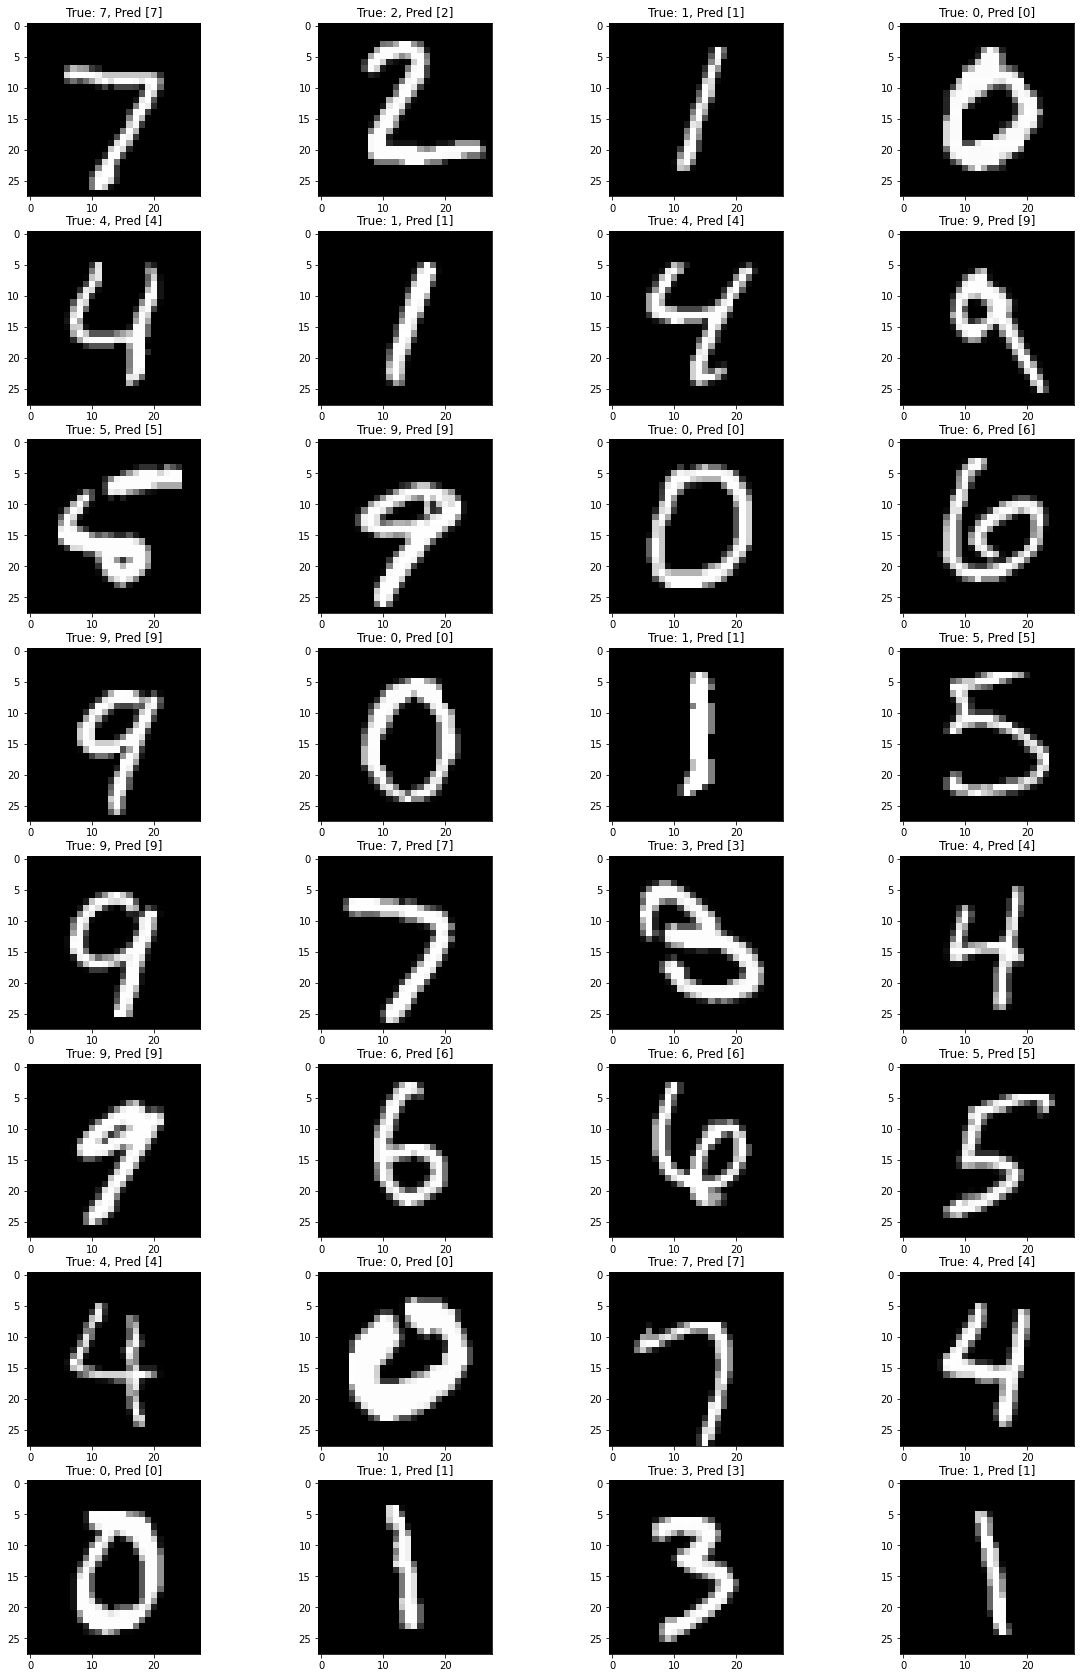

In [124]:
batch_img = enumerate(test_loader)
batch_idx, (example_data, example_targets) = next(batch_img)

with torch.no_grad():
    if train_on_gpu:
      data, target = example_data.cuda(), target.cuda()
    output = model(data)

pred_train = output.data.max(1, keepdim = True)[1]

fig, axes = plt.subplots(8, 4, figsize = (20, 30))
axes = axes.ravel()

for i in range(0, 32):
  axes[i].imshow(example_data[i][0], cmap = 'gray', interpolation = 'none')
  axes[i].set_title("True: {}, Pred {}".format(example_targets[i], pred_train.cpu().numpy()[i]))